In [10]:
import os
import math
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [11]:
from google.colab import files
uploaded = files.upload()

data_file = next(iter(uploaded.keys()))
print(f"Loaded file: {data_file}")


Saving sp500.csv to sp500.csv
Loaded file: sp500.csv


In [12]:
df = pd.read_csv(data_file)
print("Detected columns:", df.columns.tolist())

configs = {
    "data": {
        "columns": ["Close", "Volume"],
        "sequence_length": 50,
        "train_test_split": 0.85,
        "normalise": True
    },
    "training": {
        "epochs": 2,
        "batch_size": 32
    },
    "model": {
        "loss": "mse",
        "optimizer": "adam"
    }
}

# Verify columns exist
assert set(configs["data"]["columns"]).issubset(df.columns), "Expected columns not found in data."


Detected columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']


In [13]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    for i, data in enumerate(predicted_data):
        padding = [None for _ in range(i * prediction_len)]
        if i == 0:
            ax.plot(padding + data, label='Prediction')
        else:
            ax.plot(padding + data)
    plt.legend()
    plt.show()



In [14]:
class DataLoader:
    def __init__(self, dataframe, split, cols):
        i_split = int(len(dataframe) * split)
        self.data_train = dataframe[cols].values[:i_split]
        self.data_test = dataframe[cols].values[i_split:]
        self.len_train = len(self.data_train)
        self.len_test = len(self.data_test)

    def get_test_data(self, seq_len, normalise):
        data_windows = []
        for i in range(self.len_test - seq_len):
            data_windows.append(self.data_test[i:i+seq_len])
        data_windows = np.array(data_windows).astype(float)
        data_windows = self.normalise_windows(data_windows, False) if normalise else data_windows
        x = data_windows[:, :-1]
        y = data_windows[:, -1, [0]]
        return x, y

    def get_train_data(self, seq_len, normalise):
        data_x, data_y = [], []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)
        return np.array(data_x), np.array(data_y)

    def _next_window(self, i, seq_len, normalise):
        window = self.data_train[i:i+seq_len]
        window = self.normalise_windows(window, True)[0] if normalise else window
        x = window[:-1]
        y = window[-1, [0]]
        return x, y

    def normalise_windows(self, window_data, single_window=False):
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        epsilon = 1e-8
        for window in window_data:
            normalised_window = []
            for col_i in range(window.shape[1]):
                base = window[0, col_i]
                base = base if abs(base) > epsilon else epsilon
                normalised_col = [(float(p)/base) - 1 for p in window[:, col_i]]
                normalised_window.append(normalised_col)
            normalised_window = np.array(normalised_window).T
            normalised_data.append(normalised_window)
        return np.array(normalised_data)


In [15]:
input_dim = len(configs["data"]["columns"])

model = Sequential()
model.add(LSTM(100, input_shape=(49, input_dim), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(loss=configs["model"]["loss"], optimizer=configs["model"]["optimizer"])
print("Model compiled.")



Model compiled.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
data = DataLoader(df, configs["data"]["train_test_split"], configs["data"]["columns"])

x_train, y_train = data.get_train_data(
    seq_len=configs["data"]["sequence_length"],
    normalise=configs["data"]["normalise"]
)

model.fit(
    x_train, y_train,
    epochs=configs["training"]["epochs"],
    batch_size=configs["training"]["batch_size"]
)


Epoch 1/2
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - loss: 0.0019
Epoch 2/2
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - loss: 6.8675e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━

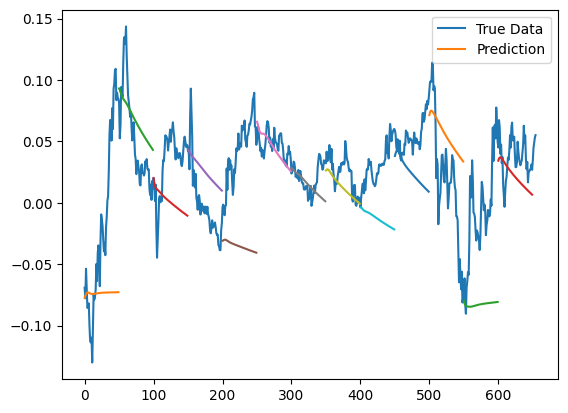

In [17]:
x_test, y_test = data.get_test_data(
    seq_len=configs["data"]["sequence_length"],
    normalise=configs["data"]["normalise"]
)

prediction_len = configs["data"]["sequence_length"]
predictions = []
for i in range(int(len(x_test)/prediction_len)):
    curr_frame = x_test[i * prediction_len]
    pred_seq = []
    for _ in range(prediction_len):
        pred = model.predict(curr_frame[np.newaxis, :, :])[0, 0]
        pred_seq.append(pred)
        curr_frame = np.vstack([curr_frame[1:], [pred] * input_dim])
    predictions.append(pred_seq)

plot_results_multiple(predictions, y_test, prediction_len)


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_predictions(y_true, y_pred_flat):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_flat))
    mae = mean_absolute_error(y_true, y_pred_flat)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

# Flatten y_test to match predictions
all_preds = [p for seq in predictions for p in seq]
all_true = y_test[:len(all_preds)].flatten()

evaluate_predictions(all_true, all_preds)


RMSE: 0.0507
MAE: 0.0374


In [19]:
from sklearn.linear_model import LinearRegression

# Prepare flattened X for baseline (merge timesteps and features)
x_train_lr = x_train.reshape((x_train.shape[0], -1))
x_test_lr = x_test.reshape((x_test.shape[0], -1))

lr_model = LinearRegression()
lr_model.fit(x_train_lr, y_train)

baseline_preds = lr_model.predict(x_test_lr)

# Evaluate baseline
baseline_rmse = np.sqrt(mean_squared_error(y_test.flatten(), baseline_preds))
baseline_mae = mean_absolute_error(y_test.flatten(), baseline_preds)

print(f"Linear Regression Baseline -> RMSE: {baseline_rmse:.4f}, MAE: {baseline_mae:.4f}")



Linear Regression Baseline -> RMSE: 0.0072, MAE: 0.0050


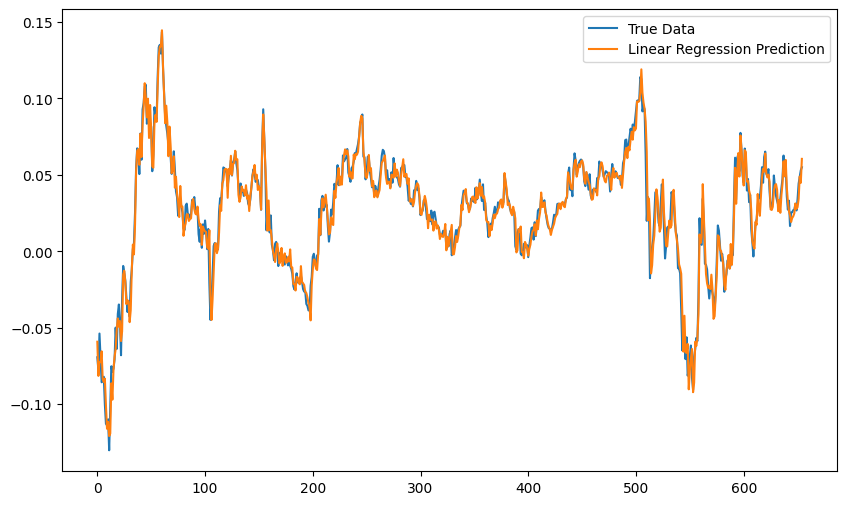

In [20]:
plt.figure(figsize=(10,6))
plt.plot(y_test.flatten(), label='True Data')
plt.plot(baseline_preds, label='Linear Regression Prediction')
plt.legend()
plt.show()

In [21]:
def build_lstm_model(input_dim, units1=100, units2=100, units3=100, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units1, input_shape=(49, input_dim), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units2, return_sequences=True))
    model.add(LSTM(units3, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer='adam')
    return model

def evaluate_predictions(y_true, y_pred_flat):
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_flat))
    mae = mean_absolute_error(y_true, y_pred_flat)
    return rmse, mae

# Configs to try: (units1, units2, units3, dropout_rate)
configs_to_try = [
    (100, 100, 100, 0.2),
    (128, 64, 64, 0.3),
    (64, 64, 32, 0.2),
    (200, 150, 100, 0.4),
    (150, 100, 50, 0.25)
]

prediction_len = configs["data"]["sequence_length"]
input_dim = len(configs["data"]["columns"])

results = []

for u1, u2, u3, dr in configs_to_try:
    print(f"\n🔹 Trying config: LSTM({u1}, {u2}, {u3}), Dropout: {dr}")
    model = build_lstm_model(input_dim, u1, u2, u3, dr)

    model.fit(
        x_train, y_train,
        epochs=configs["training"]["epochs"],
        batch_size=configs["training"]["batch_size"],
        verbose=0
    )

    # Predict multi-sequence
    predictions = []
    for i in range(int(len(x_test)/prediction_len)):
        curr_frame = x_test[i * prediction_len]
        pred_seq = []
        for _ in range(prediction_len):
            pred = model.predict(curr_frame[np.newaxis, :, :], verbose=0)[0, 0]
            pred_seq.append(pred)
            curr_frame = np.vstack([curr_frame[1:], [pred] * input_dim])
        predictions.append(pred_seq)

    all_preds = [p for seq in predictions for p in seq]
    all_true = y_test[:len(all_preds)].flatten()

    rmse, mae = evaluate_predictions(all_true, all_preds)
    print(f"✅ RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    results.append({
        "config": (u1, u2, u3, dr),
        "rmse": rmse,
        "mae": mae
    })

# Summarize all results
print("\n📊 Summary of all tried configs:")
for r in results:
    u1, u2, u3, dr = r["config"]
    print(f"LSTM({u1}, {u2}, {u3}), Dropout: {dr} -> RMSE: {r['rmse']:.4f}, MAE: {r['mae']:.4f}")



🔹 Trying config: LSTM(100, 100, 100), Dropout: 0.2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ RMSE: 0.0846, MAE: 0.0561

🔹 Trying config: LSTM(128, 64, 64), Dropout: 0.3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ RMSE: 0.0505, MAE: 0.0379

🔹 Trying config: LSTM(64, 64, 32), Dropout: 0.2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ RMSE: 0.0478, MAE: 0.0367

🔹 Trying config: LSTM(200, 150, 100), Dropout: 0.4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ RMSE: 0.0509, MAE: 0.0386

🔹 Trying config: LSTM(150, 100, 50), Dropout: 0.25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ RMSE: 0.0381, MAE: 0.0286

📊 Summary of all tried configs:
LSTM(100, 100, 100), Dropout: 0.2 -> RMSE: 0.0846, MAE: 0.0561
LSTM(128, 64, 64), Dropout: 0.3 -> RMSE: 0.0505, MAE: 0.0379
LSTM(64, 64, 32), Dropout: 0.2 -> RMSE: 0.0478, MAE: 0.0367
LSTM(200, 150, 100), Dropout: 0.4 -> RMSE: 0.0509, MAE: 0.0386
LSTM(150, 100, 50), Dropout: 0.25 -> RMSE: 0.0381, MAE: 0.0286


Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - loss: 0.0021
Epoch 2/2
124/124 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - loss: 6.6814e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49

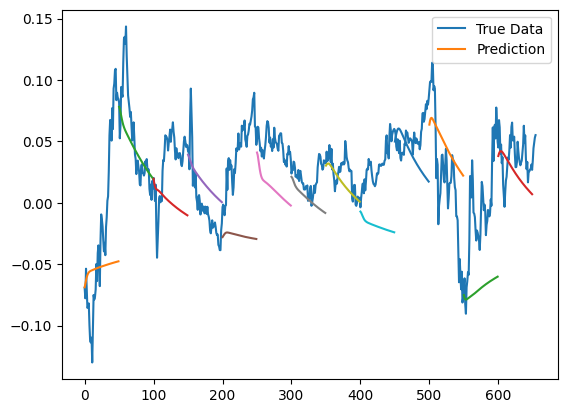

Best Config Final -> RMSE: 0.0464, MAE: 0.0356


In [22]:
# Rebuild + train best model
best_model = build_lstm_model(input_dim, 150, 100, 50, 0.25)
best_model.fit(
    x_train, y_train,
    epochs=configs["training"]["epochs"],
    batch_size=configs["training"]["batch_size"]
)

# Predict and plot
predictions = []
for i in range(int(len(x_test)/prediction_len)):
    curr_frame = x_test[i * prediction_len]
    pred_seq = []
    for _ in range(prediction_len):
        pred = best_model.predict(curr_frame[np.newaxis, :, :])[0, 0]
        pred_seq.append(pred)
        curr_frame = np.vstack([curr_frame[1:], [pred] * input_dim])
    predictions.append(pred_seq)

# Plot
plot_results_multiple(predictions, y_test, prediction_len)

# Final metrics
all_preds = [p for seq in predictions for p in seq]
all_true = y_test[:len(all_preds)].flatten()
rmse, mae = evaluate_predictions(all_true, all_preds)
print(f"Best Config Final -> RMSE: {rmse:.4f}, MAE: {mae:.4f}")
